In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
dataset = pd.read_csv(r"C:\Users\LOQ\important_features_dataset.csv")

In [29]:
X = dataset.drop('target_column', axis=1)
y = dataset['target_column']
print("Missing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

Missing values in X: 0
Missing values in y: 0


In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [31]:
class URLDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features.values)
        self.labels = torch.LongTensor(labels.values)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'labels': self.labels[idx]
        }

In [32]:
# CNN Model
class URLClassifierCNN(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super(URLClassifierCNN, self).__init__()
        
        self.features = input_dim
        
        # Reshape features into a 2D grid
        self.grid_size = int(np.ceil(np.sqrt(input_dim)))
        self.pad_size = self.grid_size * self.grid_size - input_dim
        
        # CNN layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Pad the input if necessary
        if self.pad_size > 0:
            x = torch.cat([x, torch.zeros(batch_size, self.pad_size)], dim=1)
        
        # Reshape into 2D grid
        x = x.view(batch_size, 1, self.grid_size, self.grid_size)
        
        # Forward pass through CNN layers
        x = self.conv_layers(x)
        x = x.view(batch_size, -1)
        x = self.fc_layers(x)
        
        return x

In [46]:
def train_model(model, train_loader, test_loader, device, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    
    best_accuracy = 0
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Evaluation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                features = batch['features'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}:')
        print(f'Average training loss: {avg_loss:.4f}')
        print(f'Test accuracy: {accuracy:.4f}\n')
        
        scheduler.step(accuracy)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_cnn_model.pt')
    
    return train_losses, test_accuracies

In [47]:
# Evaluation function
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(features)
            probs = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probs)

In [48]:
torch.manual_seed(42)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [49]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [50]:
X_train.shape

(520938, 16)

In [51]:
y_train.shape

(520938,)

In [52]:
X_test.shape

(130235, 16)

In [53]:
y_test.shape

(130235,)

In [54]:
# datasets
train_dataset = URLDataset(X_train, y_train)
test_dataset = URLDataset(X_test, y_test)

In [55]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [56]:
# Initialize model
input_dim = X_scaled.shape[1]
model = URLClassifierCNN(input_dim).to(device)

In [57]:
model

URLClassifierCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=4, 

C:\Users\LOQ\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [01:53<00:00, 143.98it/s]


Epoch 1:
Average training loss: 0.2633
Test accuracy: 0.9216



Epoch 2/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [01:55<00:00, 140.73it/s]


Epoch 2:
Average training loss: 0.2191
Test accuracy: 0.9279



Epoch 3/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [02:01<00:00, 134.06it/s]


Epoch 3:
Average training loss: 0.2058
Test accuracy: 0.9298



Epoch 4/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [01:51<00:00, 146.21it/s]


Epoch 4:
Average training loss: 0.1979
Test accuracy: 0.9318



Epoch 5/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [01:54<00:00, 141.57it/s]


Epoch 5:
Average training loss: 0.1928
Test accuracy: 0.9321



Epoch 6/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [01:52<00:00, 144.44it/s]


Epoch 6:
Average training loss: 0.1886
Test accuracy: 0.9323



Epoch 7/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [01:56<00:00, 139.84it/s]


Epoch 7:
Average training loss: 0.1849
Test accuracy: 0.9335



Epoch 8/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [01:54<00:00, 142.29it/s]


Epoch 8:
Average training loss: 0.1821
Test accuracy: 0.9346



Epoch 9/10: 100%|███████████████████████████████████████████████████████████████| 16280/16280 [01:51<00:00, 145.85it/s]


Epoch 9:
Average training loss: 0.1797
Test accuracy: 0.9342



Epoch 10/10: 100%|██████████████████████████████████████████████████████████████| 16280/16280 [01:52<00:00, 145.05it/s]


Epoch 10:
Average training loss: 0.1780
Test accuracy: 0.9376



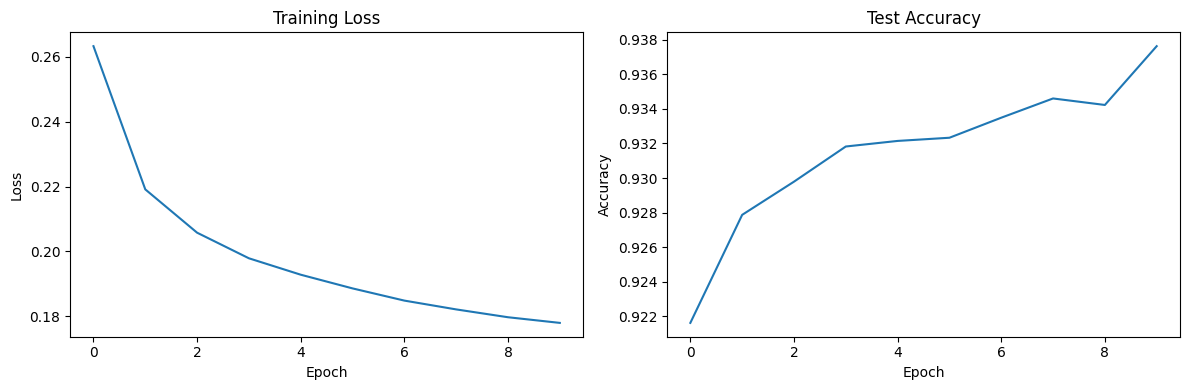

In [58]:
# Train model
train_losses, test_accuracies = train_model(model, train_loader, test_loader, device)
    
# training progress
plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')    
plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
    
plt.tight_layout()
plt.show()

In [59]:
def predict_single(features, model, device):
    model.eval()
    with torch.no_grad():
        features_tensor = torch.FloatTensor(features.values).unsqueeze(0).to(device)
        outputs = model(features_tensor)
        probs = torch.softmax(outputs, dim=1)
        prediction = torch.argmax(outputs, dim=1)
        
    return prediction.item(), probs[0].cpu().numpy()

In [60]:
# final model eval
class_names = ['benign', 'defacement', 'phishing', 'malware']
predictions, labels, probabilities = evaluate_model(model, test_loader, device, class_names)
    
# classification report
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.97      0.96     85621
  defacement       0.96      0.97      0.96     19291
    phishing       0.83      0.75      0.79     18819
     malware       0.96      0.89      0.92      6504

    accuracy                           0.94    130235
   macro avg       0.92      0.90      0.91    130235
weighted avg       0.94      0.94      0.94    130235



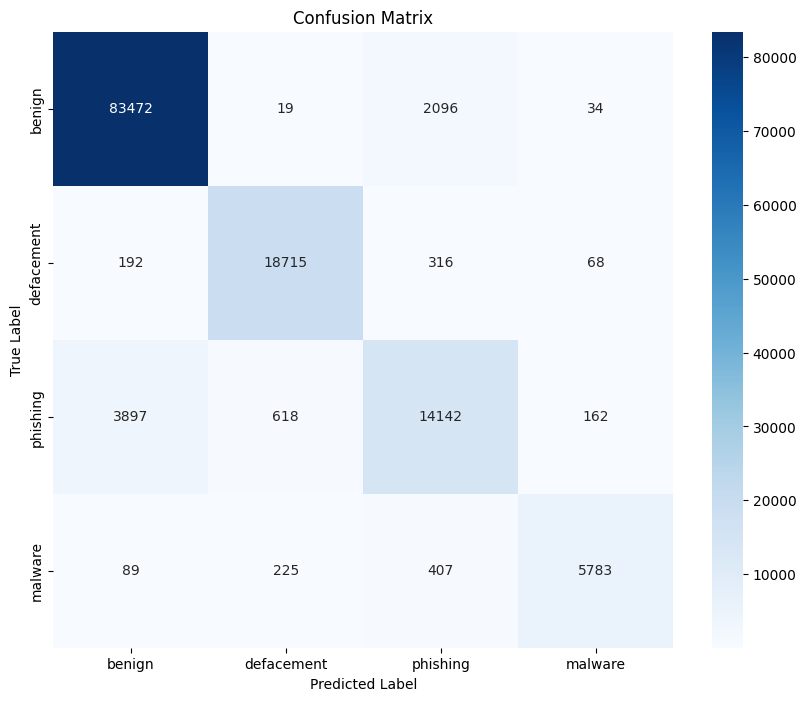

In [61]:
# confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

=============================================================================================================

### LSTM Model

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
dataset = pd.read_csv(r"C:\Users\LOQ\important_features_dataset.csv")

In [70]:
X = dataset.drop('target_column', axis=1)
y = dataset['target_column']

In [71]:
print("Missing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

Missing values in X: 0
Missing values in y: 0


In [63]:
class URLDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features.values)
        self.labels = torch.LongTensor(labels.values)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'labels': self.labels[idx]
        }

In [64]:
class URLClassifierLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_classes=4, dropout=0.5):
        super(URLClassifierLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=1,  # One feature at a time
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # * 2 for bidirectional
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        # Reshape input to (batch_size, sequence_length, input_size)
        x = x.unsqueeze(-1)  # Add input_size dimension
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Use the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        
        # Fully connected layers
        out = self.fc(lstm_out)
        return out

In [65]:
def train_model(model, train_loader, val_loader, device, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                features = batch['features'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}:')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        print('-' * 60)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pt')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [66]:
def plot_metrics(metrics):
    plt.figure(figsize=(15, 5))
    
    # losses
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # accuracies
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_accuracies'], label='Training Accuracy')
    plt.plot(metrics['val_accuracies'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            features = batch['features'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(features)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [67]:
torch.manual_seed(42)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [72]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [73]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [77]:
X_train.shape

(455821, 16)

In [78]:
y_train.shape

(455821,)

In [79]:
X_test.shape

(97676, 16)

In [80]:
y_test.shape

(97676,)

In [81]:
X_val.shape

(97676, 16)

In [82]:
y_val.shape

(97676,)

In [74]:
# datasets
train_dataset = URLDataset(X_train, y_train)
val_dataset = URLDataset(X_val, y_val)
test_dataset = URLDataset(X_test, y_test)
    
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [75]:
# Initialize model
input_dim = X_scaled.shape[1]
model = URLClassifierLSTM(input_dim=input_dim).to(device)

In [76]:
model

URLClassifierLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [83]:
# Train model
metrics = train_model(model, train_loader, val_loader, device)

Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:09<00:00, 164.01it/s]


Epoch 1:
Training Loss: 0.3687, Training Accuracy: 0.8599
Validation Loss: 0.2436, Validation Accuracy: 0.9068
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:08<00:00, 179.47it/s]


Epoch 2:
Training Loss: 0.2403, Training Accuracy: 0.9102
Validation Loss: 0.2162, Validation Accuracy: 0.9184
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:08<00:00, 177.55it/s]


Epoch 3:
Training Loss: 0.2180, Training Accuracy: 0.9187
Validation Loss: 0.1994, Validation Accuracy: 0.9227
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:02<00:00, 620.88it/s]


Epoch 4:
Training Loss: 0.2052, Training Accuracy: 0.9231
Validation Loss: 0.1868, Validation Accuracy: 0.9282
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:02<00:00, 633.49it/s]


Epoch 5:
Training Loss: 0.1971, Training Accuracy: 0.9260
Validation Loss: 0.1815, Validation Accuracy: 0.9300
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:02<00:00, 622.57it/s]


Epoch 6:
Training Loss: 0.1904, Training Accuracy: 0.9281
Validation Loss: 0.1808, Validation Accuracy: 0.9311
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:02<00:00, 634.44it/s]


Epoch 7:
Training Loss: 0.1851, Training Accuracy: 0.9295
Validation Loss: 0.1815, Validation Accuracy: 0.9312
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:02<00:00, 617.65it/s]


Epoch 8:
Training Loss: 0.1813, Training Accuracy: 0.9312
Validation Loss: 0.1717, Validation Accuracy: 0.9348
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:02<00:00, 619.64it/s]


Epoch 9:
Training Loss: 0.1784, Training Accuracy: 0.9322
Validation Loss: 0.1685, Validation Accuracy: 0.9355
------------------------------------------------------------


Validation: 100%|█████████████████████████████████████████████████████████████████| 1527/1527 [00:02<00:00, 605.77it/s]

Epoch 10:
Training Loss: 0.1749, Training Accuracy: 0.9338
Validation Loss: 0.1723, Validation Accuracy: 0.9345
------------------------------------------------------------


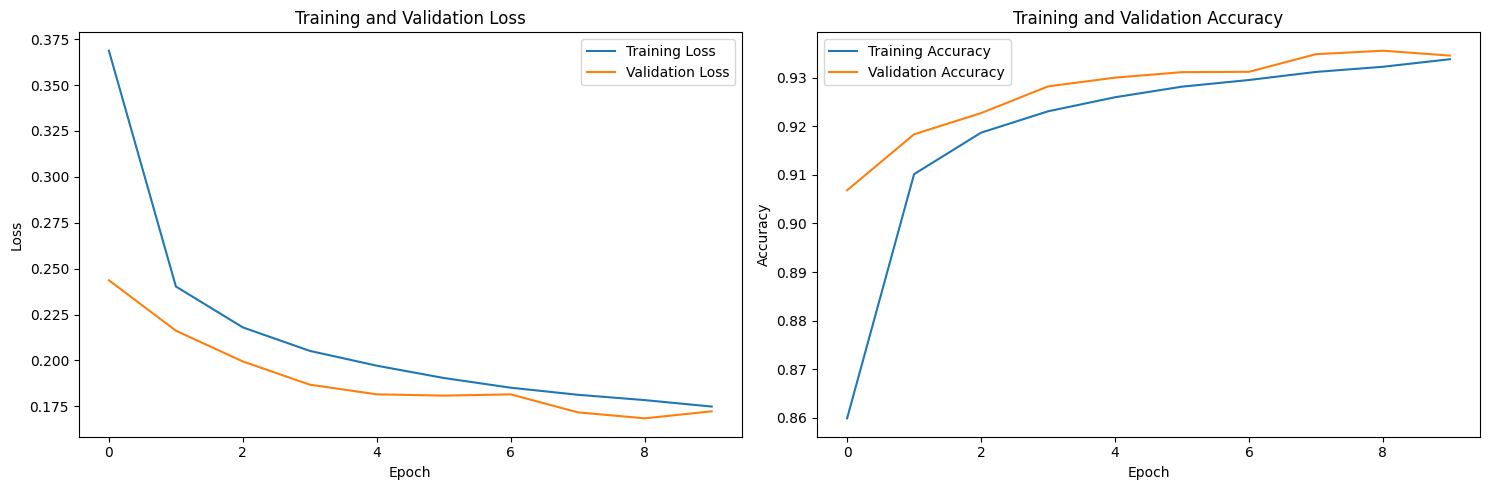

In [84]:
# training metrics
plot_metrics(metrics)

In [85]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_lstm_model.pt'))

C:\Users\LOQ\AppData\Local\Temp\ipykernel_9144\3280566309.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_lstm_model.pt'))


<All keys matched successfully>


Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.98      0.96     64216
  defacement       0.95      0.98      0.96     14468
    phishing       0.85      0.72      0.78     14114
     malware       0.96      0.89      0.92      4878

    accuracy                           0.94     97676
   macro avg       0.92      0.89      0.91     97676
weighted avg       0.93      0.94      0.93     97676



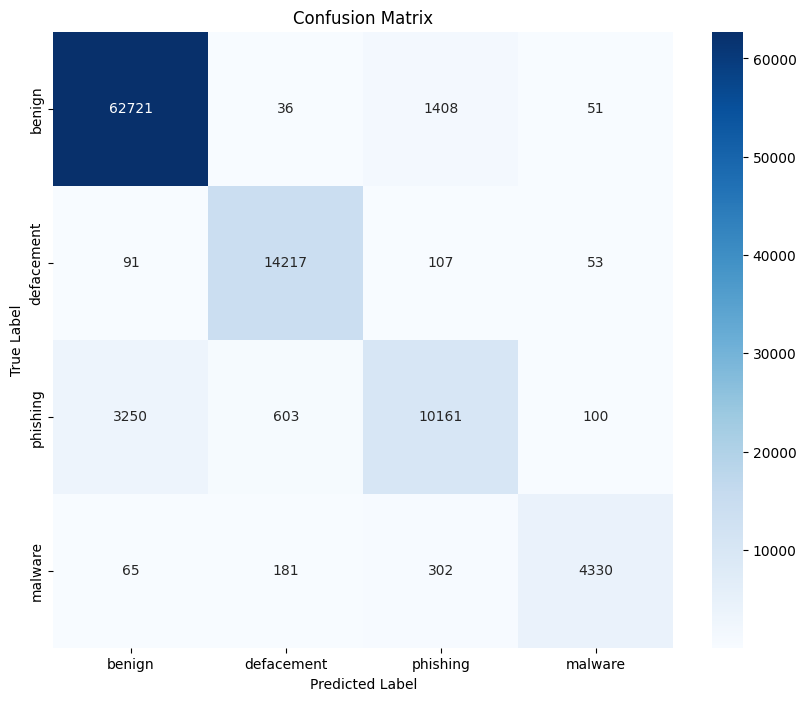

In [86]:
class_names = ['benign', 'defacement', 'phishing', 'malware']
evaluate_model(model, test_loader, device, class_names)

=========================================================================================================

### COMPARISON OF MODELS

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_accuracies = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'BERT'],
    'Accuracy': [0.94, 0.94, 0.92]
})

In [88]:
data = {
    'Class': ['Benign', 'Defacement', 'Phishing', 'Malware'] * 3,
    'Model': ['CNN'] * 4 + ['LSTM'] * 4 + ['BERT'] * 4,
    'Precision': [0.95, 0.96, 0.83, 0.96,  # CNN
                  0.95, 0.95, 0.85, 0.96,  # LSTM
                  0.94, 0.93, 0.84, 0.95], # BERT
    'Recall': [0.97, 0.97, 0.75, 0.89,     # CNN
               0.98, 0.98, 0.72, 0.89,     # LSTM
               0.98, 0.98, 0.64, 0.89],    # BERT
    'F1-Score': [0.96, 0.96, 0.79, 0.92,   # CNN
                 0.96, 0.96, 0.78, 0.92,   # LSTM
                 0.96, 0.95, 0.73, 0.92]   # BERT
}

class_metrics = pd.DataFrame(data)

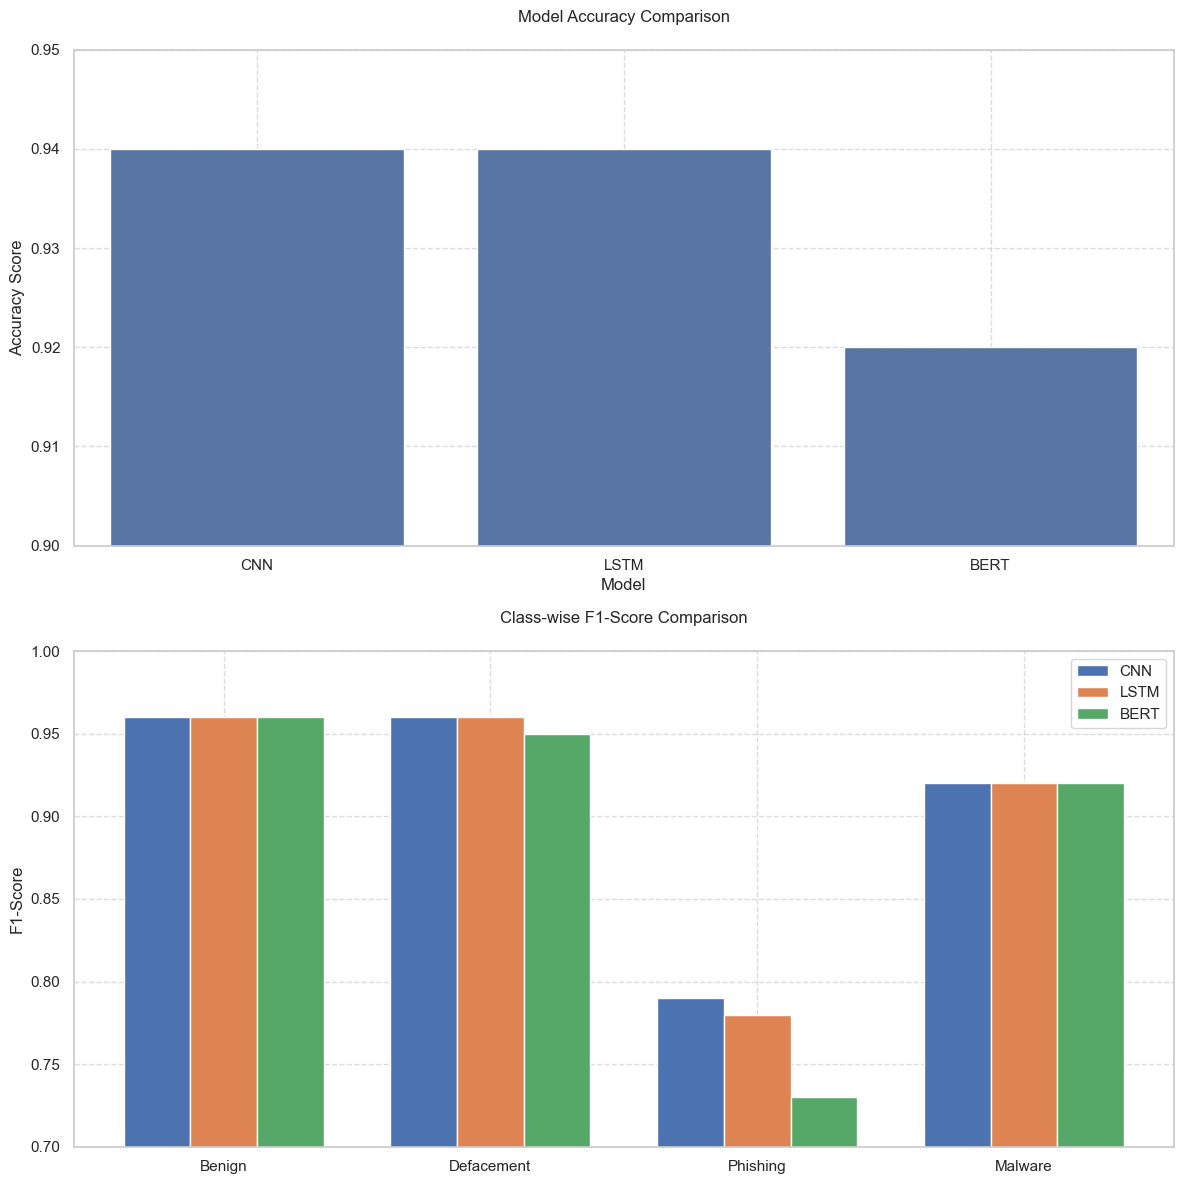

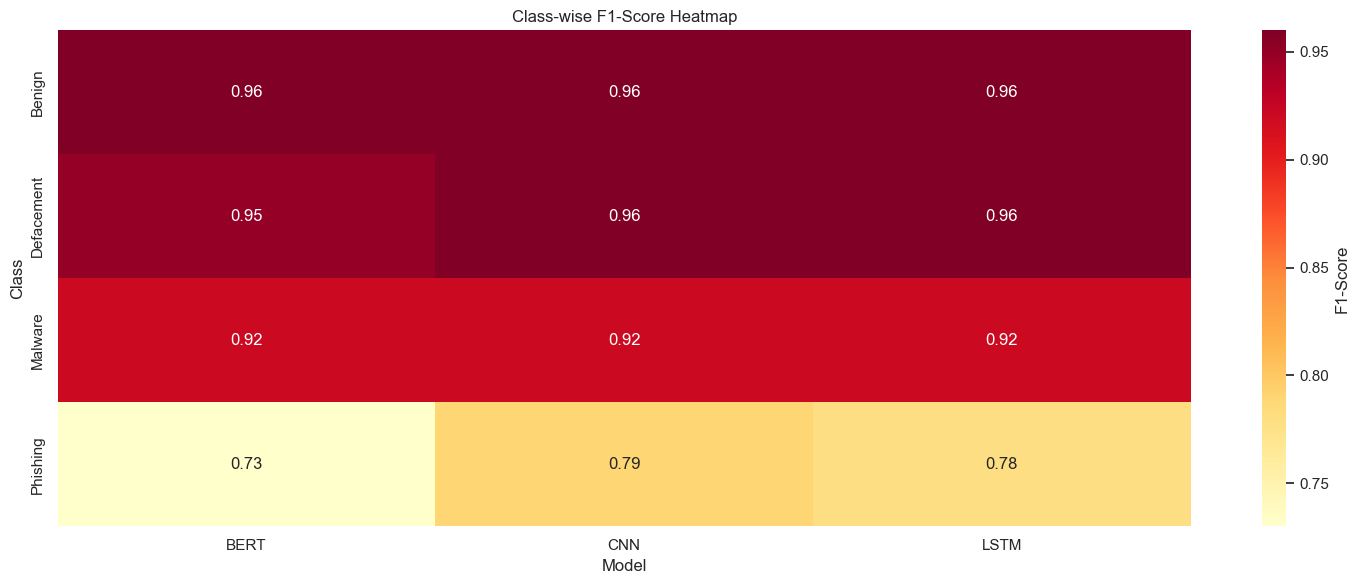

In [91]:
# style
plt.rcParams['figure.figsize'] = [12, 12]
sns.set_theme(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Average Accuracy Comparison
sns.barplot(data=model_accuracies, x='Model', y='Accuracy', ax=ax1)
ax1.set_title('Model Accuracy Comparison', pad=20)
ax1.set_ylim(0.90, 0.95)  # Set y-axis limit to better show differences
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylabel('Accuracy Score')

# Plot 2: Class-wise Performance Comparison (grouped bar plot)
x = np.arange(len(class_metrics['Class'].unique()))
width = 0.25

for i, model in enumerate(['CNN', 'LSTM', 'BERT']):
    model_data = class_metrics[class_metrics['Model'] == model]
    ax2.bar(x + i*width, model_data['F1-Score'], width, label=model)

=ax2.set_ylabel('F1-Score')
ax2.set_title('Class-wise F1-Score Comparison', pad=20)
ax2.set_xticks(x + width)
ax2.set_xticklabels(class_metrics['Class'].unique())
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

# heatmap for detailed class-wise metrics
plt.figure(figsize=(15, 6))

# Reshape data
heatmap_data = pd.pivot_table(
    class_metrics,
    values='F1-Score',
    index='Class',
    columns='Model'
)

sns.heatmap(heatmap_data, 
            annot=True, 
            cmap='YlOrRd', 
            fmt='.2f',
            cbar_kws={'label': 'F1-Score'})

plt.title('Class-wise F1-Score Heatmap')
plt.tight_layout()
plt.show()

======================================================================================================